In [1]:
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from configs import *
from fetch_data import *
from features_extraction import *
from data_shuffling_split import *
from data_preprocess import *
from ml_modeling import *

In [2]:
strat_train_set = read_csv("train/strat_train_set.csv")
strat_train_set = strat_train_set.iloc[:10000]
strat_train_set.head()

Number of instances in the file are:  449033


,id,dialect,dialect_l_encoded,text
0,1056552188082716800,LY,8,توا دوشه الكلاسيكو شن بيتمها وشن بيسكتهم وشن ب...
1,891734969202114560,SY,15,حسابشخصي في احلي من الشحاطه 😂
2,1110565179257954432,SD,14,حسابشخصي موهبه والله 😂 اوع تحاول تطورها تقوم م...
3,1172817955270340608,LB,7,حسابشخصي حسابشخصي 😂 انا صرلي عشر سنين مش مجدده...
4,293253217821790208,QA,12,احلي شعور تكون باجازه وتقوم من الصبح وتمر ع ال...


In [3]:
x_train_text, x_val_text, y_train, y_val = prepare_data(strat_train_set)

The number of instances in the training data after StratifiedShuffleSplit are:  9800
The number of instances in the testing data after StratifiedShuffleSplit are:   200
The number of trainin instances:  9800
The number of validation instances:  200
The number of trainin labels :  9800
The number of validation labels :  200


In [4]:
x_train_text_tokenized = tokenize_using_nltk_TreebankWordTokenizer(x_train_text)

print("Before Tokenization : \n", x_train_text[:3])
print("="*50)
print("After Tokenization : \n", x_train_text_tokenized[:3])
print("="*50)

x_val_text_tokenized = tokenize_using_nltk_TreebankWordTokenizer(x_val_text)

print("Before Tokenization : \n", x_val_text[:3])
print("="*50)
print("After Tokenization : \n", x_val_text_tokenized[:3])

Before Tokenization : 
 ['حسابشخصي هذا مسوي بلوك لنص الشعب لقطري ويتكلم عنه ! ! ! ! والله ان فرقاهم عيد . . . هم بالذات . #قرقاش', 'حسابشخصي حسابشخصي بالعكس الرحله وياهم احلا شي 😊 ونااسه', 'نقدر سهرهم والتعب معوضين في المره القادمه رابطويب']
After Tokenization : 
 [['حسابشخصي', 'هذا', 'مسوي', 'بلوك', 'لنص', 'الشعب', 'لقطري', 'ويتكلم', 'عنه', '!', '!', '!', '!', 'والله', 'ان', 'فرقاهم', 'عيد', '.', '.', '.', 'هم', 'بالذات', '.', '#', 'قرقاش'], ['حسابشخصي', 'حسابشخصي', 'بالعكس', 'الرحله', 'وياهم', 'احلا', 'شي', '😊', 'ونااسه'], ['نقدر', 'سهرهم', 'والتعب', 'معوضين', 'في', 'المره', 'القادمه', 'رابطويب']]
Before Tokenization : 
 ['حسابشخصي الله الله قريب ، لازم زياره ليه بعد رمضان', 'حسابشخصي يا ابني ارحمي بقي', '#برت اثاري فوزهم علينا بهالطريقه ؟ ؟ ']
After Tokenization : 
 [['حسابشخصي', 'الله', 'الله', 'قريب', '،', 'لازم', 'زياره', 'ليه', 'بعد', 'رمضان'], ['حسابشخصي', 'يا', 'ابني', 'ارحمي', 'بقي'], ['#', 'برت', 'اثاري', 'فوزهم', 'علينا', 'بهالطريقه', '؟', '؟']]


# Curse of Dimensional & sparsity

Tasks like **Computer Vision** or **Natural Language Processing** run to problem called **Curse of Dimensional**, and as we have here NLP classification problem, the number of instance are semi-large, but this not the point, the point is what we dealing with is text language, and the language are free of grammar, ritch of vocabulary and others.

So to handle like these problems we need to extract features from the text, the old or classical way is using BOW (Bag of Words), and this approach run to the problem of **Curse of Dimensionality** as we will have number of features related to the unique words in our data. Not just that most of these features are zeros, what is we called sparse matrix.

Beside of that, this matrix we will get from that approach represent the text not the word itself, so there is no similarity between words and other problem.

# Word2Vec

From what we have of these problem we moved to another approach related to the word representation.

Word2vec is numerical representation of dense vector for the word semantics of meaning, including the implies meaning of the word. So we can use these word representation in our text as we will see.

But to train Word2Vec and got a pretty good result of word representation, it first require massive data millions of text document, and second to wait for a while for your model to train. So we use the idea of transfer learning, and use some of the pre trained Arabic Word2Vec models and download it to use in our task. 

**Check for more information about the models we used:** [AraVec](https://www.sciencedirect.com/science/article/pii/S1877050917321749)



# Build Matrix of Text

Any ML or DL model require specific number of features (input) to dealing with, but what we have here with word2vec is word representation. So how it works for text ?

We will build a matrix for each text, but we need to limit the number of words in each text, because we can not train the model with different number of words in text.

# Note !

We can take the maximum number of words in the longest text, but maybe for some documents its has thousand of words, so we use the graph below and other helpful method to get reasonable length.

In [5]:
# Get how many words inside each text after tokenization
num_of_words_in_each_text = [len(text) for text in x_train_text_tokenized]
max_len = max(num_of_words_in_each_text)
print("The max length is: ", max_len)
num_of_words_in_each_text[:10]

The max length is:  80


[25, 9, 8, 10, 23, 9, 17, 11, 22, 9]

The number of keys before removing are:  72
The number of keys after removing some of them are:  0


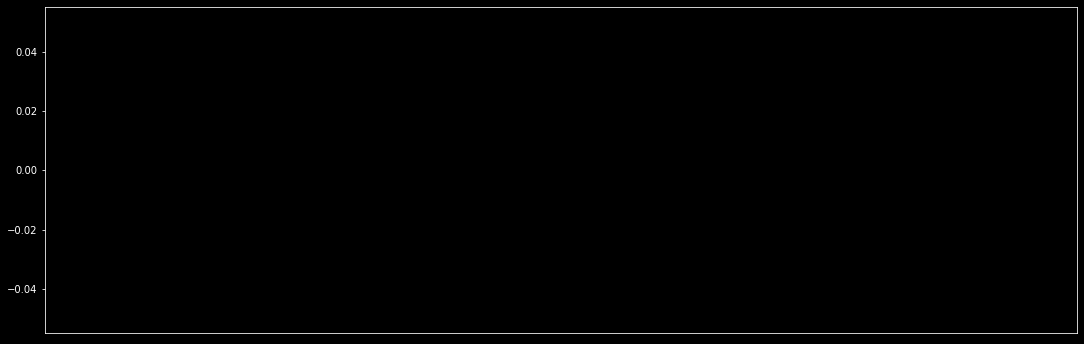

In [6]:
# count how many times these value repeated and sort them
new_dicts = get_keys_that_val_gr_than_num(num_of_words_in_each_text, 1000)
keys = list(new_dicts.keys())
values = list(new_dicts.values())
plt.style.use('dark_background')
fig = plt.gcf()
fig.set_size_inches(18.5, 6)
plt.bar(range(len(new_dicts)), values, tick_label=keys)
plt.show()

In [7]:
word_to_vec_model = load_word2vec_model("models/word2vec/bakrianoo_unigram_cbow_100_twitter/full_uni_cbow_100_twitter.mdl")

In [8]:
number_of_features = 100
max_len_str = 64
word2vec_path = "bakr/"
model_path_to_save = "models/ml_models/"
estimators = voting_models()

X_train_embed_matrix = text_to_matrix_using_word2vec(word_to_vec_model, x_train_text_tokenized, max_len_str)
X_val_embed_matrix = text_to_matrix_using_word2vec(word_to_vec_model, x_val_text_tokenized, max_len_str)

(9800, 6400)
[ 0.6406  -1.85     0.01985 -0.8535   0.3623  -2.416   -1.094   -2.168
  2.006   -2.81     1.923    0.06726  2.766   -3.68    -1.073   -1.608
 -0.6113   1.991    2.984    2.396   -2.871    0.1931   0.777    3.166
  3.594    1.499   -0.5244   2.85     1.408   -0.753    0.717   -2.047
 -0.5664   3.615   -0.06015  3.229   -2.357    4.137    1.76    -3.941
 -3.717   -0.2527  -0.2693  -2.22     1.606    3.387   -0.11206  1.086
  2.904   -1.972  ]
(200, 6400)
[ 5.44    -1.274    3.229   -3.773   -3.795    4.926   -0.6597   2.365
  0.5625  -3.352    0.3213   0.5005  -3.709   -5.33     3.615    1.654
  2.988   -0.7603   0.3733   2.418   -2.904   -2.7      2.135   -0.3982
  0.63     1.314   -0.8735   4.855    4.684   -1.277    3.67    -2.932
  2.867    2.352    2.062   -0.756   -2.1      5.863    0.9263  -0.7715
  0.5312   4.836   -0.761   -0.4324  -3.611   -1.574    0.10724 -3.316
 -1.546    3.238  ]


# Train Logistic Regression

In [9]:
model = LogisticRegression(penalty='l2', C=1, multi_class='multinomial', solver='lbfgs', verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


===================== Validate Result =====================
F1 score is:  0.235
It takes to run:  0:00:37.374069


/home/abdelrahman/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.1s finished


# Train SVC

In [10]:
model = LinearSVC(C=0.5,  verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[LibLinear]===================== Validate Result =====================
F1 score is:  0.175
It takes to run:  0:02:20.763607


/home/abdelrahman/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Hard Voting

In [11]:
model = VotingClassifier(estimators, voting="hard")
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[LibLinear]

/home/abdelrahman/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/abdelrahman/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.2s finished


===================== Validate Result =====================
F1 score is:  0.20999999999999996
It takes to run:  0:02:57.843415


# Extr Tree Classifier

In [12]:
model = ExtraTreesClassifier(n_estimators=100, max_depth=5, max_samples=.1, verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


===================== Validate Result =====================
F1 score is:  0.125
It takes to run:  0:00:05.345713


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


# AdaBoost 

In [13]:
model = LinearSVC(C=0.5,  verbose=1)
model = AdaBoostClassifier(model,  algorithm="SAMME", n_estimators=5)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]===================== Validate Result =====================
F1 score is:  0.20000000000000004
It takes to run:  0:01:03.547857


#  Gradient Boosting

In [14]:
model = GradientBoostingClassifier(n_estimators=10, subsample=.1, learning_rate=.5,   max_depth=5, verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1        1829.4357      -13114.4928            2.42m
         2        2422.3346 -1093570909.1189            2.16m
         3    29001179.7258 -10636194716047820.0000            1.83m
         4 2126700032841648.7500 -1316898463890755.0000            1.57m
         5 1157467509366.6533 -7099516442538.0000            1.31m
         6 328615268297702.1250 -16508472307225218.0000            1.05m
         7 8571820817040256.0000 -286123861372164.0000           47.30s
         8 1529202155651900.0000 -27797984350528.0000           31.77s
         9 1485625839361327.7500 -3203648492716.0000           15.94s
        10 3590186887549460.0000 -21596092330969060.0000            0.00s
===================== Validate Result =====================
F1 score is:  0.095
It takes to run:  0:02:38.593899


# XGBClassifier

In [15]:
model = XGBClassifier(max_depth=5, subsample=.1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

/home/abdelrahman/.local/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:51:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
===================== Validate Result =====================
F1 score is:  0.155
It takes to run:  0:16:52.301682


# Rezk

In [16]:
word_to_vec_model = load_word2vec_model("models/word2vec/rezk_unigram_CBOW_model/train_word2vec_cbow__window_3_min_count_300")

In [17]:
number_of_features = 300
max_len_str = 64
word2vec_path = "rezk/"
model_path_to_save = "models/ml_models/"
estimators = voting_models()

X_train_embed_matrix = text_to_matrix_using_word2vec(word_to_vec_model, x_train_text_tokenized, max_len_str)
X_val_embed_matrix = text_to_matrix_using_word2vec(word_to_vec_model, x_val_text_tokenized, max_len_str)

(9800, 19200)
[-0.1262   0.2761   0.2466  -0.3464  -0.5044   0.216    0.2651   0.05423
 -0.3276  -0.2793   0.328    0.1699  -0.05267  0.1941   0.292    0.1654
 -0.01619 -0.428    0.411    0.0927   0.271    0.6206  -0.04764  0.04465
  0.0863   0.06042  0.08374 -0.0927   0.05176 -0.1616  -0.4875   0.4932
  0.1333   0.4666   0.0387  -0.19     0.05563 -0.1526   0.549    0.2966
 -0.0969  -0.345   -0.2896  -0.0667   0.12146  0.2126   0.1146  -0.4404
 -0.1198   0.2651 ]
(200, 19200)
[-0.1262   0.2761   0.2466  -0.3464  -0.5044   0.216    0.2651   0.05423
 -0.3276  -0.2793   0.328    0.1699  -0.05267  0.1941   0.292    0.1654
 -0.01619 -0.428    0.411    0.0927   0.271    0.6206  -0.04764  0.04465
  0.0863   0.06042  0.08374 -0.0927   0.05176 -0.1616  -0.4875   0.4932
  0.1333   0.4666   0.0387  -0.19     0.05563 -0.1526   0.549    0.2966
 -0.0969  -0.345   -0.2896  -0.0667   0.12146  0.2126   0.1146  -0.4404
 -0.1198   0.2651 ]


# Train Logistic Regression

In [18]:
model = LogisticRegression(penalty='l2', C=1, multi_class='multinomial', solver='lbfgs', verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


===================== Validate Result =====================
F1 score is:  0.275
It takes to run:  0:01:27.296875


/home/abdelrahman/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


# Train SVC

In [19]:
model = LinearSVC(C=0.5,  verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[LibLinear]===================== Validate Result =====================
F1 score is:  0.24
It takes to run:  0:03:21.084786


# Bagging Classifier

In [ ]:
dec_tree_cls = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1)
model = BaggingClassifier(base_estimator=dec_tree_cls, n_estimators=100, max_samples=.2, verbose=1)
ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


# Extr Tree Classifier

In [ ]:
model = ExtraTreesClassifier(n_estimators=100, max_depth=5, max_samples=.1, verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

# AdaBoost 

In [ ]:
model = LinearSVC(C=0.5,  verbose=1)
model = AdaBoostClassifier(model,  algorithm="SAMME", n_estimators=5)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

#  Gradient Boosting

In [ ]:
model = GradientBoostingClassifier(n_estimators=10, subsample=.1, learning_rate=.5,   max_depth=5, verbose=1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

# XGBClassifier

In [ ]:
model = XGBClassifier(max_depth=5, subsample=.1)
model = ml_classifer_pipeline(model, X_train_embed_matrix, y_train, X_val_embed_matrix, y_val,word2vec_path, model_path_to_save)

# Note !

**We can use different word embedding representation, to see its effect on training.**